In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.utils import shuffle
import time

In [ ]:
!pip install qiskit-aqua==0.7
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import VQC
from qiskit.aqua.components.optimizers import SPSA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name

In [3]:
def convertData(training_size, test_size, n, gap, plot_data): 
  class_labels = [r'A', r'B']
  data = pd.read_csv('/content/dataset_competition_IBM.csv')
  data = shuffle(data.values, random_state=0)
  # print(data[:,data.shape[1]-1])
  sample_train, sample_test, label_train, label_test = \
      train_test_split(data[:,0:data.shape[1]-1], data[:,data.shape[1]-1], test_size=0.3, random_state=12)
  print(label_train)
  # Now we standardize for gaussian around 0 with unit variance
  std_scale = StandardScaler().fit(sample_train)
  sample_train = std_scale.transform(sample_train)
  sample_test = std_scale.transform(sample_test)

  # Now reduce number of features to number of qubits
  pca = PCA(n_components=n).fit(sample_train)
  sample_train = pca.transform(sample_train)
  sample_test = pca.transform(sample_test)

  # Scale to the range (-1,+1)
  samples = np.append(sample_train, sample_test, axis=0)
  minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
  sample_train = minmax_scale.transform(sample_train)
  sample_test = minmax_scale.transform(sample_test)

  # Pick training size number of samples from each distro
  training_input = {key: (sample_train[label_train == k, :])[:training_size]
                    for k, key in enumerate(class_labels)}
  test_input = {key: (sample_test[label_test == k, :])[:test_size]
                for k, key in enumerate(class_labels)}

  if plot_data:
      try:
          import matplotlib.pyplot as plt
      except ImportError:
          raise NameError('Matplotlib not installed. Please install it before plotting')
      for k in range(0, 2):
          plt.scatter(sample_train[label_train == k, 0][:training_size],
                      sample_train[label_train == k, 1][:training_size])

      plt.title("PCA dim. reduced dataset")
      plt.show()

  return sample_train, training_input, test_input, class_labels

[1. 1. 0. ... 1. 1. 0.]


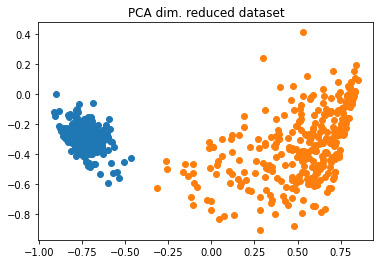

In [23]:
sample_Total, training_input, test_input, class_labels = convertData(training_size=300, test_size=60, n = 2, gap = 0.3, plot_data =True)

In [20]:
seed = 10598


backend = BasicAer.get_backend('qasm_simulator')
optimizer = SPSA(max_trials=100, c0=4.0, skip_calibration=True)
optimizer.set_options(save_steps=1)
feature_map = ZZFeatureMap(feature_dimension=2, reps=2)
var_form = TwoLocal(2, ['ry', 'rz'], 'cz', reps=3)
vqc = VQC(optimizer, feature_map, var_form, training_input, test_input)
quantum_instance = QuantumInstance(backend, shots=1021, seed_simulator=seed, seed_transpiler=seed)

In [21]:
%time result = vqc.run(quantum_instance)
print("testing success ratio: ", result['testing_accuracy'])

CPU times: user 17min 20s, sys: 558 ms, total: 17min 20s
Wall time: 27min 28s
testing success ratio:  0.9166666666666666


In [24]:
acc_test = [0.95, 0.9625, 0.9166]
time = [348, 696, 1040]
data_points = [(100, 20), (200, 40), (300, 60)]

pd.DataFrame({'Acc_test': acc_test, 'Time (s)': time, 'data_points': data_points})

,Acc_test,Time (s),data_points
0,0.9500,348,"(100, 20)"
1,0.9625,696,"(200, 40)"
2,0.9166,1040,"(300, 60)"
